In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gseapy as gsp
import seaborn as sns

In [3]:
gene_sets = {gene_set: pd.read_excel('../data/Gene pool_H7N9.xls', sheet_name=gene_set) for gene_set in ['Set 1', 'Set 2']}
gene_sets['Set 1'].head()

,GeneID,GeneDescription,per OI,per LRT
0,CD177,CD177 molecule,-0.013355,0.998697
1,MMP9,matrix metallopeptidase 9,-0.012002,0.888065
2,ALPL,"alkaline phosphatase, liver/bone/kidney",-0.008771,0.673289
3,MGAM,maltase-glucoamylase,-0.009229,0.668396
4,MCEMP1,mast cell-expressed membrane protein 1,-0.008633,0.645316


In [47]:
enrichments = {}
for key, gs_df in gene_sets.items():
    gs_df = gs_df.sort_values('per OI')
    enrichment = gsp.enrichr(gene_list = gs_df.GeneID.tolist(),
                    gene_sets = 'KEGG_2016',
                    outdir='../Enrichr' ,format='png') 
    enrichments[key] = enrichment

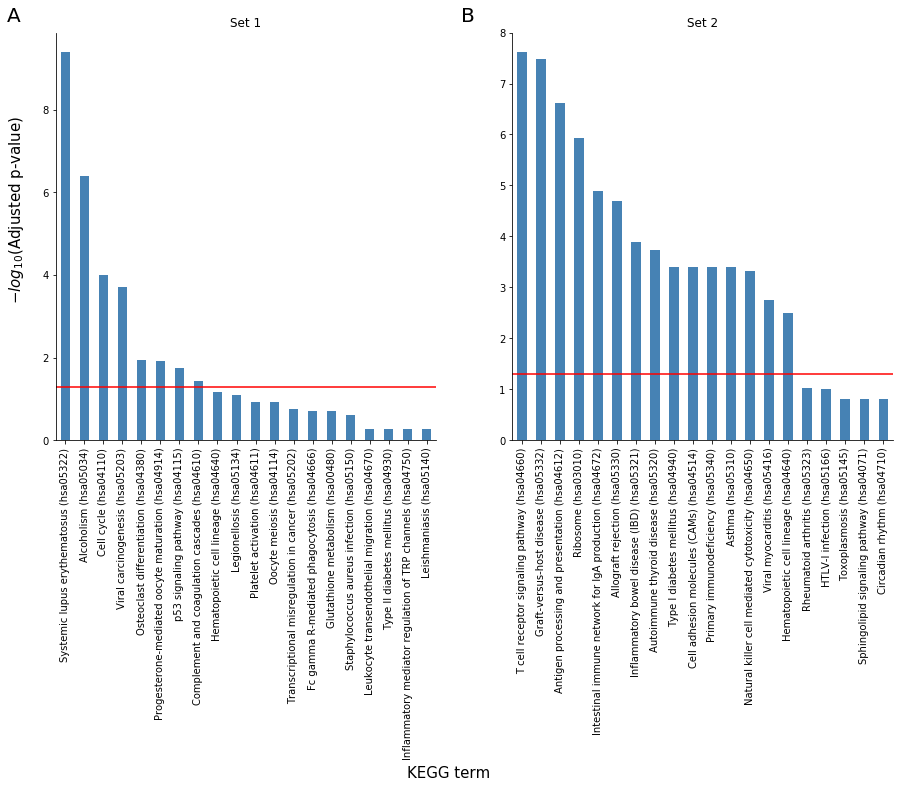

In [48]:
fig = plt.figure(figsize = (15,7.5))
for i, (gene_set, enr) in enumerate(enrichments.items()):
    ax = fig.add_subplot(1, 2, i + 1)
    enr.res2d\
        .reset_index()\
        .nsmallest(20,'Adjusted P-value')\
        .assign(log_p = lambda d: d['Adjusted P-value'].transform(lambda x: -np.log10(x)))\
        .assign(Term = lambda d: d.Term.str.replace('_Homo sapiens_',' (') + ')')\
        .plot.bar('Term','log_p', ax = ax, 
              color = 'steelblue')
    ax.hlines(xmin = -1, xmax = 100, y = -np.log10(0.05), color = 'red')
    ax.set_title(gene_set)
    #ax.set_ylim(0,0.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    ax.legend().set_visible(False)
sns.despine()
fig.text(0.08, 0.7, r'$-log_{10}$(Adjusted p-value)', size = 15, rotation= 90)
fig.text(0.45, -0.5, 'KEGG term', size = 15)
fig.text(.08,0.9,'A', size = 20)
fig.text(0.5,.9, 'B', size = 20)
figurename = '../figures/kegg_enrichment.png'
fig.savefig(figurename, bbox_inches='tight', transparent = True, dpi = 250)

In [141]:
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from Bio.Graphics.ColorSpiral import ColorSpiral
from IPython.display import Image, HTML

In [146]:
pathway_ids = ['hsa04660', #T cell
            'hsa04650', #NK cells
            'hsa04110', #cell cycle
            'hsa05322' ] #SLE
set_origins = ['Set 2', 'Set 2', 'Set 1', 'Set 1']
enriched_color = '#FFB600' #oragne
non_enriched_color = '#FFFFFF' #white
text_color = '#000000' #black

In [179]:
def plot_pathway(set_origin, pathway_id):
    enriched_genes = enrichments[set_origin]\
        .res2d\
        .pipe(lambda d: d[d.Term.str.contains(pathway_id)]) \
        .iloc[0, -1]\
        .split(';')
    print('Enriched genes: %s' %(', '.join(enriched_genes)))
    
    #grep pathway
    pathway = KGML_parser.read(kegg_get(pathway_id, "kgml"))
    
    # change color for pathway elements
    for entry in pathway.entries.values():
        if np.any(np.in1d(entry.graphics[0].name.replace(' ','').split(','), enriched_genes)):
            entry.graphics[0].bgcolor = enriched_color
            entry.graphics[0].fgcolor = text_color
        elif pathway_id == "hsa05322" and any([i in entry.graphics[0].name for i in ['HIST1H','HIST2H','FCGR','ACTN']]):
            '''
            histone gene mapping
            '''
            entry.graphics[0].bgcolor = enriched_color
            entry.graphics[0].fgcolor = text_color        
        else:
            entry.graphics[0].bgcolor = non_enriched_color
            entry.graphics[0].fgcolor = text_color
        entry.graphics[0].name = entry.graphics[0].name.split(',')[0]
    
    pathway_figure = '../figures/%s.pdf' %pathway_id
    canvas = KGMLCanvas(pathway, import_imagemap=True, fontsize=10)
    canvas.draw(pathway_figure)
    print('Drawn: ', pathway_figure)
    return pathway

In [180]:
pathways = list(map(plot_pathway, set_origins, pathway_ids))

Enriched genes: ITK, CBLB, CD3G, PIK3R1, CD3E, RASGRP1, CD3D, MALT1, PPP3CC, AKT3, CTLA4, FYN, PLCG1, ICOS, NFATC3, NFATC2, ZAP70, CD4, DLG1, CD40LG, CD8B, CD8A, LCK, CD28, PRKCQ, CD247, MAP3K14, CARD11
Drawn:  ../figures/hsa04660.pdf
Enriched genes: KIR2DS1, KLRC2, KLRC3, SH2D1A, SH2D1B, PRF1, NFATC2, GZMB, PIK3R1, KIR3DL2, KIR2DL2, KIR2DL3, NCR1, ZAP70, PPP3CC, LCK, KLRD1, CD48, FYN, KLRC1, PLCG1, CD247, CD244
Drawn:  ../figures/hsa04650.pdf
Enriched genes: GADD45A, PLK1, TTK, CDC6, CDC25C, CDC25A, CDC20, CCNA2, CCNB1, CDC45, ESPL1, ORC1, CHEK1, CDK1, BUB1
Drawn:  ../figures/hsa04110.pdf
Enriched genes: HIST1H2AM, HIST1H2AL, HIST1H2BO, HIST1H4L, HIST1H2AH, HIST1H2BI, ACTN1, HIST1H2AJ, HIST1H2BK, HIST2H2BF, HIST2H2BE, HIST1H3A, FCGR2A, HIST1H3F, HIST1H2BF, HIST1H4H, HIST1H2AD, HIST1H3G, HIST1H2BE, HIST1H2BB, HIST1H4D, HIST1H2AC, HIST1H2AB
Drawn:  ../figures/hsa05322.pdf
